# **1. Xây dựng môi trường**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder = '/content/drive/MyDrive/Tài liệu học tập/HK6/Tính toán hiệu suất cao/Đồ án cuối kỳ/NLP'

In [4]:
pip install -q underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 33.1 MB/s eta 0:00:00


In [5]:
import pandas as pd
import os
import regex
import re
import underthesea
import tensorflow as tf
import numpy as np
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from underthesea import text_normalize
from underthesea import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import json
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
import warnings
# Tắt tất cả cảnh báo
warnings.filterwarnings("ignore")

# **2.Chuẩn bị dữ liệu**

In [7]:
df = pd.read_csv(folder + '/Data/Phonefb.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8898 entries, 0 to 8897
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      8898 non-null   int64 
 1   comment    8898 non-null   object
 2   n_star     8898 non-null   int64 
 3   date_time  8898 non-null   object
 4   label      8898 non-null   object
dtypes: int64(2), object(3)
memory usage: 347.7+ KB


In [9]:
df.drop(['index', 'date_time', 'label'], axis=1, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8898 entries, 0 to 8897
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  8898 non-null   object
 1   n_star   8898 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 139.2+ KB


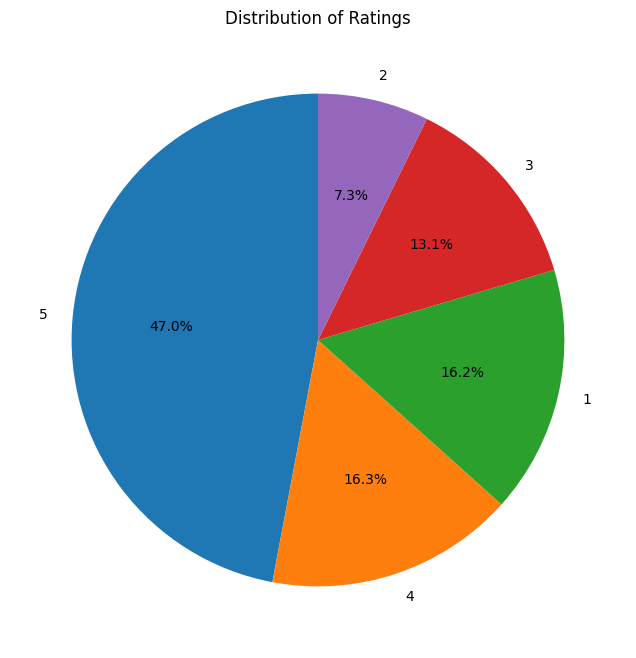

In [11]:
# Tính toán số lượng của mỗi đánh giá
n_star_counts = df['n_star'].value_counts()

# Biểu đồ tròn
plt.figure(figsize=(8, 8))
plt.pie(n_star_counts, labels=n_star_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Ratings')
plt.show()

---
# **3. Tiền xử lý dữ liệu**
---
Tiền xử lý dữ liệu tiếng Việt cho bài toán phân loại văn bản gồm các việc sau:
 * Chuẩn hóa bảng mã Unicode (đưa về Unicode tổ hợp dựng sẵn)
 * Chuẩn hóa kiểu gõ dấu tiếng Việt (dùng òa úy thay cho oà uý)
 * Thực hiện tách từ tiếng Việt (sử dụng thư viện tách từ như pyvi, underthesea, vncorenlp,…)
 * đưa về văn bản lower (viết thường)
 * Xóa các ký tự đặc biệt: “.”, “,”, “;”, “)”, …
 * Loại bỏ stopword

## 3.1 Kiểm tra bộ dữ liệu

In [12]:
def cleaner_update(text):
    return text.translate(str.maketrans('','', string.punctuation)).lower()

tokenize_df=[]
for i in range(0,len(df)):
    clean = cleaner_update(df['comment'][i])
    tokenize_df.append(underthesea.word_tokenize(clean))
print(tokenize_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
words=[]
for m in range(0,len(tokenize_df)):
    for n in range(0,len(tokenize_df[m])):
        words.append(tokenize_df[m][n])
print(words)

Output hidden; open in https://colab.research.google.com to view.

#### Xem tất cả các từ

In [13]:
def df_count_word(words_list):
  df_count = pd.DataFrame(words_list,columns=['word'])
  df_count = df_count['word'].value_counts().reset_index()
  df_count.columns = ['word', 'count']
  return df_count

def WordCloudvisualization(df_count):
  # Chuyển DataFrame thành Dictionary để sử dụng cho WordCloud
  word_dict = dict(zip(df_count['word'], df_count['count']))

  # Tạo WordCloud
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)

  # Vẽ biểu đồ WordCloud
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

def WordLine(df_count):
    # Vẽ biểu đồ đường
    plt.plot(df_count['word'], df_count['count'], linestyle='-', color='b', label='Dữ liệu mẫu')

    # Đặt tên cho trục x và y
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')

    # Thêm tiêu đề cho biểu đồ
    plt.title('Biểu đồ đường theo thứ tự tăng dần của X')

    # Hiển thị chú thích
    plt.legend()

    # Hiển thị biểu đồ
    plt.show()

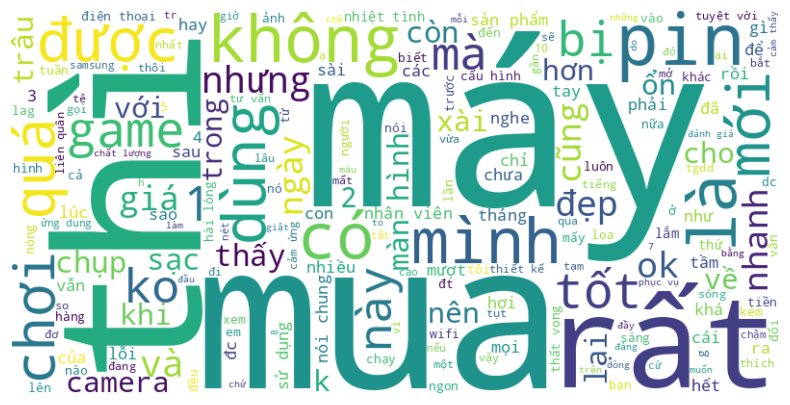

In [ ]:
WordCloudvisualization(df_count_word(words))

## Xử lý tiếng Việt

### Xử lý láy âm tiết


In [14]:
def handle_repeated_syllables(text):
    # Sử dụng regex để tìm các từ có âm tiết lặp lại (ví dụ: quááááá)
    repeated_syllables_pattern = re.compile(r'(\w+?)\1+', re.UNICODE)
    # Hàm xử lý việc loại bỏ âm tiết lặp lại
    def handle_repetition(match):
        word = match.group(1)
        # Giữ lại chỉ một phần lặp lại và thêm vào từ gốc
        return word

    # Áp dụng hàm xử lý vào chuỗi
    processed_text = repeated_syllables_pattern.sub(handle_repetition, text)
    return processed_text
# Sử dụng hàm với ví dụ
input_text = "Ngooon quááááá điiiiiiii"
output_text = handle_repeated_syllables(input_text)
print(output_text)

Ngon quá đi


### Loại bỏ các common token

In [15]:
EMAIL = re.compile(r"([\w0-9_\.-]+)(@)([\d\w\.-]+)(\.)([\w\.]{2,6})")
URL = re.compile(r"https?:\/\/(?!.*:\/\/)\S+")
PHONE = re.compile(r"(09|01[2|6|8|9])+([0-9]{9})\b")
MENTION = re.compile(r"@.+?:")
NUMBER = re.compile(r'\b\d+\S*\b')
DATETIME = '\d{1,2}\s?[/-]\s?\d{1,2}\s?[/-]\s?\d{4}'

# Delete price, 3g/4g/5g
PRICE = r'\b\d{1,4}(?:\.\d{3})*(?:\.\d+)?(?:[ktrđg])\b'

def replace_common_token(txt):
    txt = re.sub(EMAIL, ' ', txt)
    txt = re.sub(URL, ' ', txt)
    txt = re.sub(MENTION, ' ', txt)
    txt = re.sub(DATETIME, ' ', txt)
    txt = re.sub(NUMBER, ' ', txt)
    txt = re.sub(PRICE, ' ', txt)
    return txt

# Ví dụ sử dụng
text = "máy mạnh mượt trong tầm giá 3g nay 0889273527 jk mua khanhphuhv@gmail.com được giảm giá 300k còn 2690k thôi cấu hình mạnh chơi liên quân mượt nhân viên vui vẻ nhiệt tình về camera thì tạm thôi pin cực kì trâu nhưng không có sạc nhanh trải nghiệm thì thấy tất cả điều ổn ai chơi game thì chọn con này chứ chụp hình thì đừng nên mua hi vọng sài lâu không bị lỗi gì . "
text = """Mua được gần tháng từ ngày 15/7/2023 cảm thấy hài lòng
Pin trâu chơi liên quân bằng 3g liên tục đk 6-7 tiếng vẫn còn gần 40% pin
Máy đẹp sạc từ 30% lên 100% có gần 2 tiếng là đầy
Nhân viên chu đáo nhiệt tình"""
text_replace_common_token = text_normalize(handle_repeated_syllables(replace_common_token(text)))
print(text_replace_common_token)

Mua được gần tháng từ ngày cảm thấy hài lòng Pin trâu chơi liên quân bằng liên tục đk tiếng vẫn còn gần % pin Máy đẹp sạc từ % lên % có gần tiếng là đầy Nhân viên chu đáo nhiệt tình


### Loại bỏ dấu câu và ký tự xuống dòng


In [16]:
def remove_unnecessary_characters(text):
    RE_CLEAR = re.compile("[\n\r]+")# Thay thế các chuỗi xuống dòng (\n hoặc \r) bằng một ký tự trắng
    text = re.sub(RE_CLEAR, ' ', text)
    # Sử dụng string.punctuation để lấy tất cả các ký tự dấu câu
    translator = str.maketrans('', '', string.punctuation)
    # Loại bỏ dấu câu từ văn bản sử dụng bảng dịch (translator)
    text = text.translate(translator)

    return text

# Ví dụ sử dụng
text = """Đây là một đoạn__' văn bản,
 có chứa dấu câu! Xin  chào các bạn."""
text_without_punctuation = remove_unnecessary_characters(text)
print(text_without_punctuation)

Đây là một đoạn văn bản  có chứa dấu câu Xin  chào các bạn


### Chuẩn hóa các từ viết tắt cơ bản


In [ ]:
# (Ví dụ: k, ko, k0 --> không, bt --> bình thường,...)

In [17]:
def normalize_acronyms(text, teencode_file=folder+'/Data/teencode.xlsx'):
    # Đọc dữ liệu từ tệp Excel teencode.xlsx
    teencode_df = pd.read_excel(teencode_file, header=None, names=['teencode', 'replace'])

    words = []
    for word in text.strip().split():
        word = word.strip(string.punctuation)
        # Tìm kiếm trong teencode_df và thay thế
        replacement = teencode_df.loc[teencode_df['teencode'].str.lower() == word, 'replace'].values
        if len(replacement) > 0:
            words.append(replacement[0])
        else:
            words.append(word)

    return ' '.join(words)

# Sử dụng hàm normalize_acronyms với tệp Excel teencode.xlsx
input_text = "ko biết tại sao ad tại ntn"
output_text = normalize_acronyms(input_text)
print(output_text)

không biết tại sao admin tại như thế nào


### Tổng hợp lần 1

In [18]:
def text_preprocess(text):
    # 1. Chuẩn hóa văn bản tiếng việt
    text = text_normalize(text)
    # 2. Xử lý láy âm tiết
    text = handle_repeated_syllables(text)
    # 3. Loại bỏ các common token
    text = replace_common_token(text)
    # 4. Xóa bỏ dấu câu
    text = remove_unnecessary_characters(text)
    # 5. Đưa về lower
    text = text.lower()
    # 7. Chuẩn hóa các từ viết tắt cơ bản
    text = normalize_acronyms(text)
    return text

# Sử dụng lớp TextPreprocess
text_to_preprocess = """Mua được gần tháng từ ngày 15/7/2023 cảm thấy hài lòng
Pin trâu chơi liên quân bằng 3g liên tục đk 6-7 tiếng vẫn còn gần 40% pin
Máy đẹp sạc từ 30% lên 100% có gần 2 tiếng là đầy
Nhân viên chu đáo nhiệt tình"""

preprocessed_text = text_preprocess(text_to_preprocess)
preprocessed_text

'mua được gần tháng từ ngày cảm thấy hài lòng pin trâu chơi liên quân bằng g liên tục được tiếng vẫn còn gần pin máy đẹp sạc từ lên có gần tiếng là đầy nhân viên chu đáo nhiệt tình'

In [ ]:
df["comment_clean"] = df['comment'].apply(text_preprocess)
df

,comment,n_star,comment_clean
0,Mới mua máy này Tại thegioididong thốt nốt cảm...,5,mới mua máy này tại thegioidong thốt nốt cảm t...
1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,5,pin kém còn lại miễn chê mua tình trạng pin cò...
2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,3,sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...
3,"Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...",3,mọi người cập nhật phần mềm lại nó sẽ bớt tốn ...
4,"Mới mua Sài được 1 tháng thấy pin rất trâu, Sà...",5,mới mua xài được tháng thấy pin rất trâu xài b...
...,...,...,...
8893,Mua về xài hơn tháng giờ sạc không vào pin. Gử...,1,mua về xài hơn tháng giờ sạc không vào pin gửi...
8894,Mới mua cái samsung A10s sài chưa đầy 1 tháng ...,1,mới mua cái samsung a10s xài chưa đầy tháng mà...
8895,máy sử dụng mượt thiết kế rất ok. pin cũng khá...,5,máy sử dụng mượt thiết kế rất ok pin cũng khá ...
8896,"Máy có mẫu mã đẹp, pin sử dụng được 2 ngày, gi...",5,máy có mẫu mã đẹp pin sử dụng được ngày giá ph...


### Tải bộ từ điển tiếng việt

In [ ]:
# Chia các từ trong cột "comment_clean" theo khoảng trắng
no_tokenize_df=[]
for i in range(0,len(df)):
    clean = cleaner_update(df['comment_clean'][i])
    no_tokenize_df.append(clean.split())

words_no_token=[]
for m in range(0,len(no_tokenize_df)):
    for n in range(0,len(no_tokenize_df[m])):
        words_no_token.append(no_tokenize_df[m][n])
df_words_no_token = df_count_word(words_no_token) # lấy tất cả các từ đơn trong df

In [ ]:
# Lấy từ điển tiếng việt
vocabulary = []
file_path = folder + "/Data/words.txt"

with open(file_path, "r", encoding="utf-8") as file:
    for line in file:
        # print(line.strip())
        vocabulary.append(line.strip())

vocab_in_dict = pd.DataFrame([json.loads(vocab) for vocab in vocabulary]) # Lấy thấy cả từ trong từ điển

In [ ]:
# Chuyển thành các từ đơn và loại bỏ trùng lặp
vid = vocab_in_dict['text']
word_dict = []

for v in vid:
    word_dict += (v.lower().split(' '))

word_dict_ = list(set(word_dict))

In [ ]:
# Chuẩn hóa cho các từ trong từ điển
word_dict = []
for word in word_dict_:
  word = text_normalize(word)
  word_dict.append(word)

In [ ]:
# Kiểm tra những từ nào không có trong từ điển tiếng Việt
words_in_comment = df_words_no_token['word']
word_not_in_dict = []
for wic in words_in_comment:
    if wic not in word_dict:
        word_not_in_dict.append(wic)

In [ ]:
# chuyển thành df và sắp xếp theo thứ tự alphabel
not_vietnamese = pd.DataFrame(word_not_in_dict, columns=['word'])
not_vietnamese.sort_values(by='word')

,word
1977,10
145,a1
133,a10
95,a10s
163,a12
...,...
1238,🤬
487,🤮
2502,🤳
928,🥴


In [ ]:
not_vietnamese.to_csv(folder+'/Data/not_vietnamese.csv')

In [ ]:
not_vietnamese = pd.read_csv(folder + '/Data/not_vietnamese.csv')

#### Xử lý các từ viết dính nhau

In [ ]:
# Lấy các từ không phải tiếng việt dài hơn 6 (từ tiếng việt dài nhất là 6 chữ)
not_vietnamese_than_6 = not_vietnamese[not_vietnamese['word'].apply(lambda x: len(x) > 6)].reset_index(drop=True)
words_no_token_than_6=[]
for m in range(0,len(not_vietnamese_than_6)):
        words_no_token_than_6.append(not_vietnamese_than_6['word'][m].lower())
words_no_token_than_6

['samsung',
 'facebook',
 'youtube',
 'facebok',
 'android',
 'bluetoth',
 'mesenger',
 'thegioidong',
 'snapdragon',
 'smartphone',
 'comment',
 'youtobe',
 'flagship',
 'blutoth',
 'frefire',
 'onscren',
 'blackbery',
 'vinsmart',
 'mediatek',
 'ip7plus',
 'maxseting',
 'setings',
 'vingroup',
 'bthuong',
 'note8pro',
 'vietnam',
 'naitrim',
 'mobistar',
 'reviewer',
 'loading',
 'restore',
 'legends',
 'active3',
 'bluetoh',
 'youtubi',
 'netflix',
 'vinaphone',
 'megapixel',
 'youtuber',
 'smatphone',
 'nhanhso',
 'asistant',
 'dienmayxanh',
 'iphone6',
 'androi10',
 'not8pro',
 'vinfast',
 'qualcom',
 'vinmart',
 'nhanhko',
 'feedback',
 'ngonbổrẻ',
 'vismart',
 'instagram',
 'camrera',
 'xmobile',
 'pinthua',
 'livestream',
 'quyếtmáy',
 's10like',
 'myvietel',
 'phẩmvừa',
 'nhanhcamara',
 'đẹpchống',
 'tốtnhiều',
 'tốtchụp',
 'thoigioidong',
 'websendosopelazada',
 'apksure',
 'lênxuống',
 'ngàyđầu',
 'ninomax',
 'nhanhmạnhmượt',
 'telegram',
 'fulhdcon',
 'control',
 'premision

In [ ]:
def stuck_words(text):
  for i in range(1,len(text)):
      word1 = text[:i]
      word2 = text[i:]
      if word1 in word_dict and word2 in word_dict:
          text_after = word1 + ' ' + word2
          return text_after
          break
text = 'khámbệnh'
stuck_words(text)

'khám bệnh'

In [ ]:
# Gán các giá trị có thể tách ra vào cột mới stuck_word
not_vietnamese_than_6['stuck_word'] = float('nan')
for i in not_vietnamese_than_6['word']:
    not_vietnamese_than_6.loc[not_vietnamese_than_6['word'] == i, 'stuck_word'] = stuck_words(i)

In [ ]:
df_stuck_words = not_vietnamese_than_6.dropna()
df_stuck_words # Bộ từ bị dính nhau và được tách ra trong df

,word,stuck_word
0,samsung,sam sung
40,nhanhso,nhanh so
49,nhanhko,nhanh ko
56,pinthua,pin thua
58,quyếtmáy,quyết máy
61,phẩmvừa,phẩm vừa
63,đẹpchống,đẹp chống
64,tốtnhiều,tốt nhiều
65,tốtchụp,tốt chụp
69,lênxuống,lên xuống


In [ ]:
def normalize_stuck(text, df_stuck_words=df_stuck_words):
    words = []
    for word in text.strip().split():
        word = word.strip(string.punctuation)
        # Tìm kiếm trong teencode_df và thay thế
        replacement = df_stuck_words.loc[df_stuck_words['word'].str.lower() == word, 'stuck_word'].values
        if len(replacement) > 0:
            words.append(replacement[0])
        else:
            words.append(word)

    return ' '.join(words)

# Sử dụng hàm normalize_acronyms với tệp Excel teencode.xlsx
input_text = "ko biết tại sao thựcmáy lại đi hơinhanh"
output_text = normalize_stuck(input_text)
print(output_text)

ko biết tại sao thực máy lại đi hơi nhanh


#### Xử lý các từ không có nghĩa ít hơn 3 chữ

In [ ]:
not_vietnamese_less_3 = not_vietnamese[not_vietnamese['word'].apply(lambda x: len(x) < 3)].reset_index(drop=True)
not_vietnamese_less_3

,word
0,lq
1,ap
2,ip
3,️
4,😊
...,...
332,✓
333,đě
334,̉
335,nh


In [ ]:
not_vietnamese_less_3 = list(set(not_vietnamese_less_3['word']))
# Qua kiểm tra thấy các từ không phải tiếng việt ngắn hơn 3 hầu hết không có nghĩa, nên thực hiện đưa các từ này vào stopword để loại bỏ

### Loại bỏ các stopword tiếng Việt


In [ ]:
def load_data(txt_file):
    """
    Each document is one line, documents is already preprocess like: remove truncate, tokenize, strip, ...
    :param txt_file: path/to/text/file
    :return: list of documents
    """
    texts = []
    with open(txt_file, 'r', encoding='utf8') as fp:
        for line in fp.readlines():
            texts.append(line.strip())
    return texts


def get_stopwords(documents, threshold=3):
    """
    :param documents: list of documents
    :param threshold:
    :return: list of words has idf <= threshold
    """
    tfidf = TfidfVectorizer(min_df=100)
    tfidf_matrix = tfidf.fit_transform(documents)
    features = tfidf.get_feature_names_out()
    stopwords = []
    print(min(tfidf.idf_), max(tfidf.idf_), len(features))
    for index, feature in enumerate(features):
        if tfidf.idf_[index] <= threshold:
            stopwords.append(feature)
    return stopwords


def check_stopwords_in_file(word_list, file_path):
    # Đọc nội dung từ file stopword.txt
    with open(file_path, 'r', encoding='utf-8') as file:
        stopword_content = file.read()

    # Kiểm tra từng từ trong danh sách
    stopwords_found = [word for word in word_list if word in stopword_content]

    return stopwords_found

# loại stopword khỏi dữ liệu
def remove_stopwords(line):
    words = []
    for word in line.strip().split():
        if word not in stopword:
            words.append(word)
    return ' '.join(words)

In [ ]:
# Danh sách từ cần kiểm tra
stopwords = get_stopwords(load_data(folder + r"/Data/Phonefbcmt.txt"), threshold=10)
# Đường dẫn đến file stopword.txt
stopword_file_path = folder + "/Data/stopwords.txt"
# Kiểm tra các từ trong danh sách có trong stopword.txt không
stopword = check_stopwords_in_file(stopwords, stopword_file_path)
# Hiển thị kết quả
print("Các từ có trong stopword.txt:", stopword)

1.8882133616242154 5.689802497620871 466
Các từ có trong stopword.txt: ['ai', 'anh', 'biết', 'bạn', 'bằng', 'bị', 'cao', 'cho', 'chính', 'chưa', 'chỉ', 'các', 'còn', 'có', 'cùng', 'cũ', 'cũng', 'cả', 'của', 'do', 'em', 'gian', 'gì', 'hay', 'hơn', 'hận', 'hết', 'hỏi', 'khi', 'khá', 'khác', 'không', 'luôn', 'là', 'làm', 'lên', 'lại', 'lần', 'lớn', 'muốn', 'mà', 'mình', 'một', 'mới', 'ng', 'ngày', 'người', 'nh', 'nhiều', 'nhà', 'như', 'nhưng', 'nhất', 'nhận', 'những', 'nào', 'này', 'nên', 'nó', 'nói', 'năm', 'nếu', 'phải', 'qua', 'quá', 'ra', 'rất', 'rồi', 'sau', 'sẽ', 'số', 'sự', 'theo', 'tháng', 'thì', 'thường', 'thấy', 'thể', 'thời', 'thực', 'trong', 'trên', 'trước', 'tôi', 'tại', 'tất', 'tới', 'từ', 'việc', 'và', 'vào', 'vì', 'vẫn', 'về', 'với', 'vừa', 'đa', 'đang', 'đi', 'điều', 'đây', 'đã', 'đó', 'được', 'đến', 'đề', 'đều', 'để', 'ơn', 'ưng']


In [ ]:
len(stopword)

110

In [ ]:
# Không bỏ từ không
if "không" in stopword:
    stopword.remove("không")
print("Các từ có trong stopword.txt:", stopword)

Các từ có trong stopword.txt: ['ai', 'anh', 'biết', 'bạn', 'bằng', 'bị', 'cao', 'cho', 'chính', 'chưa', 'chỉ', 'các', 'còn', 'có', 'cùng', 'cũ', 'cũng', 'cả', 'của', 'do', 'em', 'gian', 'gì', 'hay', 'hơn', 'hận', 'hết', 'hỏi', 'khi', 'khá', 'khác', 'luôn', 'là', 'làm', 'lên', 'lại', 'lần', 'lớn', 'muốn', 'mà', 'mình', 'một', 'mới', 'ng', 'ngày', 'người', 'nh', 'nhiều', 'nhà', 'như', 'nhưng', 'nhất', 'nhận', 'những', 'nào', 'này', 'nên', 'nó', 'nói', 'năm', 'nếu', 'phải', 'qua', 'quá', 'ra', 'rất', 'rồi', 'sau', 'sẽ', 'số', 'sự', 'theo', 'tháng', 'thì', 'thường', 'thấy', 'thể', 'thời', 'thực', 'trong', 'trên', 'trước', 'tôi', 'tại', 'tất', 'tới', 'từ', 'việc', 'và', 'vào', 'vì', 'vẫn', 'về', 'với', 'vừa', 'đa', 'đang', 'đi', 'điều', 'đây', 'đã', 'đó', 'được', 'đến', 'đề', 'đều', 'để', 'ơn', 'ưng']


In [ ]:
stopword = stopword + not_vietnamese_less_3
print(stopword)

['ai', 'anh', 'biết', 'bạn', 'bằng', 'bị', 'cao', 'cho', 'chính', 'chưa', 'chỉ', 'các', 'còn', 'có', 'cùng', 'cũ', 'cũng', 'cả', 'của', 'do', 'em', 'gian', 'gì', 'hay', 'hơn', 'hận', 'hết', 'hỏi', 'khi', 'khá', 'khác', 'luôn', 'là', 'làm', 'lên', 'lại', 'lần', 'lớn', 'muốn', 'mà', 'mình', 'một', 'mới', 'ng', 'ngày', 'người', 'nh', 'nhiều', 'nhà', 'như', 'nhưng', 'nhất', 'nhận', 'những', 'nào', 'này', 'nên', 'nó', 'nói', 'năm', 'nếu', 'phải', 'qua', 'quá', 'ra', 'rất', 'rồi', 'sau', 'sẽ', 'số', 'sự', 'theo', 'tháng', 'thì', 'thường', 'thấy', 'thể', 'thời', 'thực', 'trong', 'trên', 'trước', 'tôi', 'tại', 'tất', 'tới', 'từ', 'việc', 'và', 'vào', 'vì', 'vẫn', 'về', 'với', 'vừa', 'đa', 'đang', 'đi', 'điều', 'đây', 'đã', 'đó', 'được', 'đến', 'đề', 'đều', 'để', 'ơn', 'ưng', 'zl', 'k4', 'đg', 'a7', 'ls', 'sv', '😣', 'hã', 'ja', '❤', 'áh', 'xr', 'lỳ', 'bl', '̣', 'dp', '😃', 'pr', 'kj', 'ds', 'bk', 'pm', 'ón', '😉', 'dg', 'vễ', '😫', 'vừ', 'pv', 'ip', '。', 't4', 'hj', 'sữ', 'vể', '℅', 'k2', 'k3', '̉

In [ ]:
def save_list_to_txt(my_list, file_path):
    """
    Lưu danh sách vào một file văn bản.

    Parameters:
    - my_list: Danh sách cần lưu.
    - file_path: Đường dẫn của file văn bản.

    Returns:
    None
    """
    with open(file_path, 'w', encoding='utf-8') as file:
        for item in my_list:
            file.write(str(item) + '\n')
# Lưu lại để dùng sau này
save_list_to_txt(stopword, folder + '/Data/stopword_train.txt')

In [ ]:
stopword = []
with open(folder + '/Data/stopword_train.txt', 'r', encoding='utf8') as fp:
    for line in fp.readlines():
        stopword.append(line.strip())
len(stopword)

446

In [ ]:
remove_stopwords('ừm có bị khùm đâu mà im lặng mìh')

'khùm đâu im lặng mìh'

### Tổng hợp lần 2

In [ ]:
def text_preprocess2(text):
    # 7. Tách các từ viết dính nhau
    text = normalize_stuck(text)
    # 8. Loại bỏ các stopword tiếng Việt
    text = remove_stopwords(text)
    # 9. Loại bỏ các khoảng trắng liên tiếp
    RE_CLEAR = re.compile("\s+") # Các khoảng trắng liên tiếp
    text = re.sub(RE_CLEAR,' ', text)
    return text

# Sử dụng lớp TextPreprocess
text_to_preprocess = """hơinhanh  ừm quá r đó, có gì đâu, bị gì á a7, ln"""

preprocessed_text = text_preprocess2(text_to_preprocess)
preprocessed_text

'hơi nhanh r đâu á'

In [ ]:
df["comment_clean2"] = df['comment_clean'].apply(text_preprocess2)
df

,comment,n_star,comment_clean,comment_clean2
0,Mới mua máy này Tại thegioididong thốt nốt cảm...,5,mới mua máy này tại thegioidong thốt nốt cảm t...,mới mua máy này tại thegioidong thốt nốt cảm t...
1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,5,pin kém còn lại miễn chê mua tình trạng pin cò...,pin kém còn lại miễn chê mua tình trạng pin cò...
2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,3,sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...
3,"Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...",3,mọi người cập nhật phần mềm lại nó sẽ bớt tốn ...,mọi người cập nhật phần mềm lại nó sẽ bớt tốn ...
4,"Mới mua Sài được 1 tháng thấy pin rất trâu, Sà...",5,mới mua xài được tháng thấy pin rất trâu xài b...,mới mua xài được tháng thấy pin rất trâu xài b...
...,...,...,...,...
8893,Mua về xài hơn tháng giờ sạc không vào pin. Gử...,1,mua về xài hơn tháng giờ sạc không vào pin gửi...,mua về xài hơn tháng giờ sạc không vào pin gửi...
8894,Mới mua cái samsung A10s sài chưa đầy 1 tháng ...,1,mới mua cái samsung a10s xài chưa đầy tháng mà...,mới mua cái samsung a10s xài chưa đầy tháng mà...
8895,máy sử dụng mượt thiết kế rất ok. pin cũng khá...,5,máy sử dụng mượt thiết kế rất ok pin cũng khá ...,máy sử dụng mượt thiết kế rất ok pin cũng khá ...
8896,"Máy có mẫu mã đẹp, pin sử dụng được 2 ngày, gi...",5,máy có mẫu mã đẹp pin sử dụng được ngày giá ph...,máy có mẫu mã đẹp pin sử dụng được ngày giá ph...


## Kiểm tra
Có comment nào không hợp lệ không (quá ngắn hoặc quá dài)

In [ ]:
# Tính độ dài của mỗi dòng trong cột "comment" và lưu kết quả vào cột mới "comment_length"
df['comment_length'] = df['comment_clean2'].apply(lambda x: len(str(x)))

# Độ dài ngắn nhất
min_length = df['comment_length'].min()

# Độ dài dài nhất
max_length = df['comment_length'].max()

# In kết quả
print(f"Độ dài ngắn nhất: {min_length}")
print(f"Độ dài dài nhất: {max_length}")

Độ dài ngắn nhất: 8
Độ dài dài nhất: 796


In [ ]:
df_min = df['comment_clean2'][df['comment_clean'].str.len() == min_length]
df_min

5493    hài lòng
Name: comment_clean2, dtype: object

In [ ]:
df_max = df['comment_clean2'][df['comment_clean'].str.len() == max_length]
print(df_max)

3698    thứ nhất độ sáng không auto xem facebok và nhắ...
Name: comment_clean2, dtype: object


## Tokenizing


### Tách từ tiếng Việt (Postagging)

In [ ]:
# def pos_tagging_vietnamese(sentence):
#     # Thực hiện POS tagging
#     tags = pos_tag(sentence)

#     # Hiển thị kết quả
#     for word, tag in tags:
#         print(f"{word}: {tag}")

# # Sử dụng hàm
# sentence = "Tôi là sinh viên trường Đại học Kinh tế"
# pos_tagging_vietnamese(sentence)

In [ ]:
# Word segmentation
def word_segmentation(text):
    text = underthesea.word_tokenize(text, format="text")
    return text

In [ ]:
df['comment_token'] = df['comment_clean2'].apply(word_segmentation)

## Vector hóa dữ liệu


In [ ]:
# # Chọn 100 dòng ngẫu nhiên
# sample_size = 50
# sampled_data = pd.DataFrame()

# # Lặp qua từng lớp trong cột target
# for rating_class in df['n_star'].unique():
#     # Lấy mẫu 100 dòng từ mỗi lớp
#     class_sample = df[df['n_star'] == rating_class].sample(sample_size, replace=True)

#     # Thêm vào DataFrame kết quả
#     sampled_data = sampled_data.append(class_sample, ignore_index=True)

# # Hiển thị DataFrame chứa mẫu cân bằng
# print(sampled_data)

                                               comment  n_star  \
0    Một chiếc máy tuyệt vời, mọi thứ đều hoàn hảo,...       5   
1    Máy xài tốt nhé\nPin trâu, chụp hình đẹp\nNói ...       5   
2    sau một tháng sử dụng tôi thấy so với tầm giá ...       5   
3    mua về xài thì cảm thấy rất mượt chơi free fir...       5   
4    Sản phẩm đẹp các góc phải thiết kế như galaxy ...       5   
..                                                 ...     ...   
245  Vừa mua xong . Mn người nên đặc hàng online tr...       4   
246  Mọi thứ đều OK, mỗi tội sạc máy rất nóng, k hi...       4   
247  Máy tốt,pin khá trâu,nhưng hơi tiếc là ko có c...       4   
248  Máy to cầm rất chắc tay có điều phụ kiện Đi kè...       4   
249  Pin thì ổn , đt chơi mượt nữa em tí lắm nhân v...       4   

                                         comment_clean  \
0    một chiếc máy tuyệt vời mọi thứ đều hoàn hảo d...   
1    máy xài tốt nhé pin trâu chụp hình đẹp nói chu...   
2    sau một tháng sử dụng tôi th

In [ ]:
df.to_csv(folder + '/Data/Phonefb_clean.csv')

In [ ]:
df = pd.read_csv(folder + '/Data/Phonefb_clean.csv')

In [ ]:
X, y = df['comment_token'], df['n_star']
# X, y = sampled_data['comment_token'], sampled_data['n_star']

In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
# X_train, X_test, y_train, y_test = train_test_split(df['comment_token'], df['n_star'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Comment

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(1, 5), stop_words=stopword, max_df=0.5, min_df=5)
tfidf_vectorizer = TfidfTransformer(use_idf=False, sublinear_tf = True, norm='l2', smooth_idf=True)

X_train = count_vectorizer.fit_transform(X_train)
X_train = tfidf_vectorizer.fit_transform(X_train)

X_test = count_vectorizer.transform(X_test)
X_test = tfidf_vectorizer.transform(X_test)

# Xây dựng và huấn luyện mô hình

## Học máy: naive_bayes

In [ ]:
# Khởi tạo mô hình MultinomialNB
naive_bayes_classifier = MultinomialNB()

# Thiết lập các tham số cần tìm kiếm
parameters = {
    'force_alpha' : (True, False),
    'fit_prior': (True, False),
    'alpha': (1, 0.1, 0.01)
}

# Khởi tạo GridSearchCV với mô hình, tham số và số lượng fold trong cross-validation (cv)
grid_search_nb = GridSearchCV(estimator=naive_bayes_classifier, param_grid=parameters, cv=5, scoring='accuracy')

# Huấn luyện GridSearchCV trên dữ liệu
grid_search_nb.fit(X_train, y_train)

# In ra các tham số tốt nhất
print("Best Parameters:", grid_search_nb.best_params_)

Best Parameters: {'alpha': 0.1, 'fit_prior': True, 'force_alpha': True}


In [ ]:
best_parameters = grid_search_nb.best_params_
# Best Parameters = {'alpha': 0.1, 'fit_prior': True, 'force_alpha': True}

# Lấy ra giá trị của mỗi tham số
best_force_alpha = best_parameters['force_alpha']
best_fit_prior = best_parameters['fit_prior']
best_alpha = best_parameters['alpha']

# Xây dựng mô hình MultinomialNB
nb_model = MultinomialNB(force_alpha = best_force_alpha, fit_prior = best_fit_prior, alpha = best_alpha)
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=0.1, force_alpha=True)

In [ ]:
# Dự đoán trên tập val
y_pred_nb = nb_model.predict(X_test)

# Đánh giá mô hình bằng các chỉ số
report1 = metrics.classification_report(y_test, y_pred_nb, digits=3)
print(report1)

              precision    recall  f1-score   support

           1      0.557     0.731     0.633       279
           2      0.364     0.034     0.063       117
           3      0.355     0.270     0.307       222
           4      0.306     0.182     0.228       286
           5      0.746     0.906     0.819       876

    accuracy                          0.626      1780
   macro avg      0.466     0.425     0.410      1780
weighted avg      0.572     0.626     0.581      1780



In [ ]:
# Tính fbeta score
def fbeta(y_true, y_pred):
	return fbeta_score(y_true, y_pred, average='weighted', beta=np.sqrt(5))
fbeta(y_test, y_pred_nb)

0.6086909088838615

In [ ]:
nb_model.fit(X_train, y_train)
y_pred_nbtrain = nb_model.predict(X_train)
report2 = metrics.classification_report(y_train, y_pred_nbtrain, digits=3)
print(report2)

              precision    recall  f1-score   support

           1      0.693     0.881     0.776      1164
           2      0.976     0.379     0.545       531
           3      0.745     0.599     0.664       946
           4      0.736     0.470     0.574      1168
           5      0.791     0.938     0.858      3309

    accuracy                          0.765      7118
   macro avg      0.788     0.653     0.683      7118
weighted avg      0.774     0.765     0.749      7118



In [ ]:
#CROSS VALIDATION
cross_score = cross_val_score(nb_model, X_train,y_train, cv=10)
cross_score

array([0.6011236 , 0.61235955, 0.58988764, 0.58848315, 0.59269663,
       0.5997191 , 0.58567416, 0.56601124, 0.59915612, 0.60196906])

## Maxent classifier: LogisticRegression

In [ ]:
# Tạo mô hình Logistic Regression (Softmax Regression)
model = LogisticRegression()

# Định nghĩa các tham số cần tối ưu
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l2'],
              'multi_class': ['multinomial'],
              'solver' : ['lbfgs','sag','saga','newton-cg']
              }

# Tạo đối tượng GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Thực hiện grid search trên tập huấn luyện
grid_search.fit(X_train, y_train)

# Hiển thị kết quả tối ưu
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'C': 1, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}


In [ ]:
# Best parameters:  {'C': 1, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
best_parameters = grid_search.best_params_
# Lấy ra giá trị của mỗi tham số
best_C = best_parameters['C']
best_solver = best_parameters['solver']
best_multi_class = best_parameters['multi_class']
best_penalty = best_parameters['penalty']

# Huấn luyện mô hình Maxent (Logistic Regression)
maxent_model = LogisticRegression(C=best_C, solver=best_solver, multi_class=best_multi_class, penalty=best_penalty)
maxent_model.fit(X_train, y_train)

LogisticRegression(C=1, multi_class='multinomial', solver='saga')

In [ ]:
# Dự đoán trên tập kiểm tra
y_pred_lr = maxent_model.predict(X_test)
# Đánh giá mô hình bằng các chỉ số
report1 = metrics.classification_report(y_test, y_pred_lr, digits=3)
print(report1)

              precision    recall  f1-score   support

           1      0.572     0.699     0.629       279
           2      0.312     0.043     0.075       117
           3      0.340     0.248     0.286       222
           4      0.349     0.203     0.257       286
           5      0.733     0.917     0.815       876

    accuracy                          0.627      1780
   macro avg      0.461     0.422     0.412      1780
weighted avg      0.570     0.627     0.581      1780



In [ ]:
fbeta(y_test, y_pred_lr)

0.6093883271836834

In [ ]:
maxent_model.fit(X_train, y_train)
y_pred_lrtrain = maxent_model.predict(X_train)
report2 = metrics.classification_report(y_train, y_pred_lrtrain, digits=3)
print(report2)

              precision    recall  f1-score   support

           1      0.665     0.827     0.737      1164
           2      0.870     0.151     0.257       531
           3      0.658     0.499     0.568       946
           4      0.694     0.378     0.490      1168
           5      0.752     0.960     0.844      3309

    accuracy                          0.721      7118
   macro avg      0.728     0.563     0.579      7118
weighted avg      0.725     0.721     0.688      7118



In [ ]:
#CROSS VALIDATION
cross_score = cross_val_score(maxent_model, X_train,y_train, cv=10)
cross_score

array([0.60252809, 0.61235955, 0.58707865, 0.59691011, 0.5997191 ,
       0.59129213, 0.58426966, 0.6011236 , 0.59634318, 0.60337553])

## Học sâu: LTSM

In [ ]:
# @title Data split
X, y = df['comment_token'], df['n_star']

# OneHotEncoder
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(y.values.reshape(-1, 1))
y = encoded_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

count_vectorizer = CountVectorizer(ngram_range=(1, 5), stop_words=stopword, max_df=0.5, min_df=5)
tfidf_vectorizer = TfidfTransformer(use_idf=False, sublinear_tf = True, norm='l2', smooth_idf=True)

X_train = count_vectorizer.fit_transform(X_train)
X_train = tfidf_vectorizer.fit_transform(X_train)

X_test = count_vectorizer.transform(X_test)
X_test = tfidf_vectorizer.transform(X_test)

In [ ]:
# @title LSTM
X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

y_train_array = y_train.toarray()
y_test_array = y_test.toarray()

max_length = X_train_array.shape[1]
vocab_size = X_train_array.shape[1]

# Xây dựng mô hình LSTM
model = Sequential()
model.add(Embedding(X_train_array.shape[1], 128, input_length=max_length))
model.add(LSTM(128))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Huấn luyện mô hình (tăng epoch lên khoảng 500-1000)
history = model.fit(X_train_array, y_train_array, batch_size=32, epochs=50, validation_split=0.2)

# Dự đoán nhãn cho dữ liệu mới
predicted_scores = model.predict(X_test_array)
predicted_scores = encoder.inverse_transform(predicted_scores)

# Hiển thị dự đoán
for i, score in enumerate(predicted_scores):
    print(f"Bình luận {i+1}: Điểm dự đoán - {score}")

In [ ]:
y_test = encoder.inverse_transform(y_test_array)

# Đánh giá mô hình bằng các chỉ số
report1 = metrics.classification_report(y_test, predicted_scores, digits=3)
print(report1)

In [ ]:
fbeta(y_test, predicted_scores)

# Đánh giá

### Tạo hàm so sánh

In [ ]:
def compare_models(model1, model2, df = df):
    """
    So sánh kết quả giữa hai mô hình trên tập kiểm tra.

    Parameters:
    - model1: Mô hình 1 đã được huấn luyện.
    - model2: Mô hình 2 đã được huấn luyện.
    - X: Dữ liệu đầu vào.
    - y: Nhãn.

    Returns:
    - report1: Bảng đánh giá cho mô hình 1.
    - report2: Bảng đánh giá cho mô hình 2.
    """

    X, y = df['comment_token'], df['n_star']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
    count_vectorizer = CountVectorizer(ngram_range=(1, 5), stop_words=stopword, max_df=0.5, min_df=5)
    tfidf_vectorizer = TfidfTransformer(use_idf=False, sublinear_tf = True, norm='l2', smooth_idf=True)

    X_train = count_vectorizer.fit_transform(X_train)
    X_train = tfidf_vectorizer.fit_transform(X_train)

    X_test = count_vectorizer.transform(X_test)
    X_test = tfidf_vectorizer.transform(X_test)

    model1.fit(X_train, y_train)
    model2.fit(X_train, y_train)

    # Dự đoán trên tập kiểm tra
    y_pred1 = model1.predict(X_test)
    y_pred2 = model2.predict(X_test)

    # Bảng đánh giá cho mô hình 1
    report1 = metrics.classification_report(y_test, y_pred1, labels=[1, 2, 3, 4, 5], digits=3)

    # Bảng đánh giá cho mô hình 2
    report2 = metrics.classification_report(y_test, y_pred2, labels=[1, 2, 3, 4, 5], digits=3)

    return report1, report2



## Đánh giá 2 model

In [ ]:
# Sử dụng hàm so sánh
maxent_model = LogisticRegression(C=best_C, solver=best_solver, multi_class=best_multi_class, penalty=best_penalty)
nb_model = MultinomialNB(force_alpha = best_force_alpha, fit_prior = best_fit_prior, alpha = best_alpha)

result_report1, result_report2 = compare_models(maxent_model, nb_model, df)

# In bảng đánh giá
print("Classification Report for Logistic Regression model:")
print(result_report1)
print("------------------------------")
print("Classification Report for Naive Bayes model:")
print(result_report2)

Classification Report for Logistic Regression model:
              precision    recall  f1-score   support

           1      0.572     0.699     0.629       279
           2      0.267     0.034     0.061       117
           3      0.342     0.248     0.287       222
           4      0.351     0.206     0.260       286
           5      0.733     0.917     0.815       876

    accuracy                          0.627      1780
   macro avg      0.453     0.421     0.410      1780
weighted avg      0.567     0.627     0.581      1780

------------------------------
Classification Report for Naive Bayes model:
              precision    recall  f1-score   support

           1      0.557     0.731     0.633       279
           2      0.364     0.034     0.063       117
           3      0.355     0.270     0.307       222
           4      0.306     0.182     0.228       286
           5      0.746     0.906     0.819       876

    accuracy                          0.626      1780
  

## Xử lý mất cân bằng

#### Giảm mẫu

In [ ]:
# Chia dữ liệu thành các lớp
class_1 = df[df['n_star'] == 1]
class_2 = df[df['n_star'] == 2]
class_3 = df[df['n_star'] == 3]
class_4 = df[df['n_star'] == 4]
class_5 = df[df['n_star'] == 5]

# Xác định lớp có số lượng mẫu ít nhất
min_samples_class = min(len(class_1), len(class_2), len(class_3), len(class_4), len(class_5))

# Giảm mẫu của các lớp khác để đảm bảo không vượt quá số lượng mẫu ít nhất
class_1_downsampled = resample(class_1, replace=False, n_samples=min_samples_class)
class_2_downsampled = resample(class_2, replace=False, n_samples=min_samples_class)
class_3_downsampled = resample(class_3, replace=False, n_samples=min_samples_class)
class_4_downsampled = resample(class_4, replace=False, n_samples=min_samples_class)
class_5_downsampled = resample(class_5, replace=False, n_samples=min_samples_class)

# Kết hợp lại thành DataFrame mới cân bằng
balanced_df_less = pd.concat([class_1_downsampled, class_2_downsampled, class_3_downsampled, class_4_downsampled, class_5_downsampled]).reset_index()

# In thông tin DataFrame cân bằng
balanced_df_less

,index,Unnamed: 0,comment,n_star,comment_clean,comment_clean2,comment_length,comment_token
0,256,256,"Máy gì mà chậm với nóng bực cả mình, pin thì d...",1,máy gì mà chậm với nóng bực cả mình pin thì dù...,máy gì mà chậm với nóng bực cả mình pin thì dù...,60,máy gì mà chậm với nóng bực_cả mình pin thì dù...
1,3470,3470,Oppo A91 chụp rất nét nhưng sao gửi hình ảnh l...,1,opo a91 chụp rất nét nhưng sao gửi hình ảnh lê...,opo a91 chụp rất nét nhưng sao gửi hình ảnh lê...,83,opo a91 chụp rất nét nhưng sao gửi hình_ảnh lê...
2,6690,6690,Mình nghỉ ss nên coi lại cách làm dt của mình ...,1,mình nghỉ s nên coi lại cách làm điện thoại củ...,mình nghỉ s nên coi lại cách làm điện thoại củ...,143,mình nghỉ s nên coi lại cách làm điện_thoại củ...
3,1833,1833,Máy mau hết pin.ra điện máy xanh kêu trả ko ki...,1,máy mau hết pinra điện máy xanh kêu trả không ...,máy mau hết pinra điện máy xanh kêu trả không ...,88,máy mau hết pinra điện_máy xanh kêu trả không ...
4,7514,7514,"Pin tuột nhanh, camera trước và chụp cực tệ. M...",1,pin tuột nhanh camera trước và chụp cực tệ mặt...,pin tuột nhanh camera trước và chụp cực tệ mặt...,128,pin tuột nhanh camera trước và chụp cực_tệ mặt...
...,...,...,...,...,...,...,...,...
3235,8004,8004,"Máy tốt ,dùng rất mượt ,chơi game ổn ko lag đô...",5,máy tốt dùng rất mượt chơi game ổn không lag đ...,máy tốt dùng rất mượt chơi game ổn không lag đ...,86,máy tốt dùng rất mượt_chơi game ổn không lag đ...
3236,272,272,Mới mua đc 1tuần. Rất hài lòng. Pin khá trâu. ...,5,mới mua được tuần rất hài lòng pin khá trâu cả...,mới mua được tuần rất hài lòng pin khá trâu cả...,161,mới mua được tuần rất hài_lòng pin khá trâu cả...
3237,6813,6813,"Tôi mua cũng được 3 tháng rồi rất mượt, chơi g...",5,tôi mua cũng được tháng rồi rất mượt chơi game...,tôi mua cũng được tháng rồi rất mượt chơi game...,169,tôi mua cũng được tháng rồi rất mượt_chơi game...
3238,599,599,"rất đẹp, rất tinh xảo và còn sang trọng quyền ...",5,rất đẹp rất tinh xảo và còn sang trọng quyền q...,rất đẹp rất tinh xảo và còn sang trọng quyền q...,103,rất đẹp rất tinh_xảo và còn sang_trọng quyền q...


In [ ]:
balanced_df_less['n_star'].value_counts()

In [ ]:
# Sử dụng hàm so sánh
maxent_model = LogisticRegression(C=best_C, solver=best_solver, multi_class=best_multi_class, penalty=best_penalty)

nb_model = MultinomialNB(force_alpha = best_force_alpha, fit_prior = best_fit_prior, alpha = best_alpha)

result_report1, result_report2 = compare_models(maxent_model, nb_model, balanced_df_less)

# In bảng đánh giá
print("Classification Report for Logistic Regression model:")
print(result_report1)
print("------------------------------")
print("Classification Report for Naive Bayes model:")
print(result_report2)

Classification Report for Logistic Regression model:
              precision    recall  f1-score   support

           1      0.534     0.503     0.518       157
           2      0.296     0.280     0.288       132
           3      0.298     0.320     0.308       122
           4      0.433     0.388     0.409       116
           5      0.621     0.719     0.667       121

    accuracy                          0.443       648
   macro avg      0.436     0.442     0.438       648
weighted avg      0.439     0.443     0.440       648

------------------------------
Classification Report for Naive Bayes model:
              precision    recall  f1-score   support

           1      0.561     0.497     0.527       157
           2      0.302     0.288     0.295       132
           3      0.282     0.303     0.292       122
           4      0.393     0.397     0.395       116
           5      0.578     0.645     0.609       121

    accuracy                          0.427       648
  

#### Tăng mẫu

In [ ]:
# Xác định features (X) và target (y)
X = df.drop('n_star', axis=1)
y = df['n_star']

# Sử dụng RandomOverSampler để tăng mẫu
oversampler = RandomOverSampler(sampling_strategy='auto')
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Tạo DataFrame mới từ dữ liệu tăng mẫu
balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='n_star')], axis=1)

# In thông tin DataFrame cân bằng
balanced_df

,Unnamed: 0,comment,comment_clean,comment_clean2,comment_length,comment_token,n_star
0,0,Mới mua máy này Tại thegioididong thốt nốt cảm...,mới mua máy này tại thegioidong thốt nốt cảm t...,mới mua máy này tại thegioidong thốt nốt cảm t...,166,mới mua máy này tại thegioidong thốt nốt cảm_t...,5
1,1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,pin kém còn lại miễn chê mua tình trạng pin cò...,pin kém còn lại miễn chê mua tình trạng pin cò...,69,pin kém còn lại miễn_chê mua tình_trạng pin cò...,5
2,2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,86,sao lúc gọi điện_thoại màn_hình bị chấm nhỏ nh...,3
3,3,"Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...",mọi người cập nhật phần mềm lại nó sẽ bớt tốn ...,mọi người cập nhật phần mềm lại nó sẽ bớt tốn ...,106,mọi người cập_nhật phần_mềm lại nó sẽ bớt tốn ...,3
4,4,"Mới mua Sài được 1 tháng thấy pin rất trâu, Sà...",mới mua xài được tháng thấy pin rất trâu xài b...,mới mua xài được tháng thấy pin rất trâu xài b...,206,mới mua xài được tháng thấy pin rất trâu xài b...,5
...,...,...,...,...,...,...,...
20920,2388,"Máy đẹp, nhìn sang trọng. Nhưng giá còn hơi c...",máy đẹp nhìn sang trọng nhưng giá còn hơi cao ...,máy đẹp nhìn sang trọng nhưng giá còn hơi cao ...,88,máy đẹp nhìn sang_trọng nhưng giá còn hơi cao ...,4
20921,6752,Sản phẩm đc TGDD gửi hàng đã đc bóc có hoá dơn...,sản phẩm được tgd gửi hàng đã được bóc có hóa ...,sản phẩm được tgd gửi hàng đã được bóc có hóa ...,146,sản_phẩm được tgd gửi hàng đã được bóc có hóa_...,4
20922,2269,"M mua dịp sinh nhật của tgdđ , m mua con nà...",mình mua dịp sinh nhật của tgdđ mình mua con n...,mình mua dịp sinh nhật của tgdđ mình mua con n...,143,mình mua dịp sinh_nhật của tgdđ mình mua con n...,4
20923,4503,Máy có mỗi màn hình không sắc nét lắm .còn lại...,máy có mỗi màn hình không sắc nét lắm còn lại ...,máy có mỗi màn hình không sắc nét lắm còn lại ...,97,máy có mỗi màn_hình không sắc nét lắm còn lại ...,4


In [ ]:
# Sử dụng hàm so sánh
maxent_model = LogisticRegression(C=best_C, solver=best_solver, multi_class=best_multi_class, penalty=best_penalty)

nb_model = MultinomialNB(force_alpha = best_force_alpha, fit_prior = best_fit_prior, alpha = best_alpha)

result_report1, result_report2 = compare_models(maxent_model, nb_model, balanced_df)

# In bảng đánh giá
print("Classification Report for Logistic Regression model:")
print(result_report1)
print("------------------------------")
print("Classification Report for Naive Bayes model:")
print(result_report2)

Classification Report for Logistic Regression model:
              precision    recall  f1-score   support

           1      0.804     0.852     0.828       833
           2      0.919     0.888     0.903       851
           3      0.788     0.772     0.780       869
           4      0.735     0.694     0.714       798
           5      0.733     0.769     0.751       834

    accuracy                          0.796      4185
   macro avg      0.796     0.795     0.795      4185
weighted avg      0.797     0.796     0.796      4185

------------------------------
Classification Report for Naive Bayes model:
              precision    recall  f1-score   support

           1      0.736     0.896     0.808       833
           2      1.000     0.705     0.827       851
           3      0.866     0.738     0.797       869
           4      0.729     0.613     0.666       798
           5      0.633     0.880     0.736       834

    accuracy                          0.767      4185
  

In [ ]:
balanced_df['n_star'].value_counts()

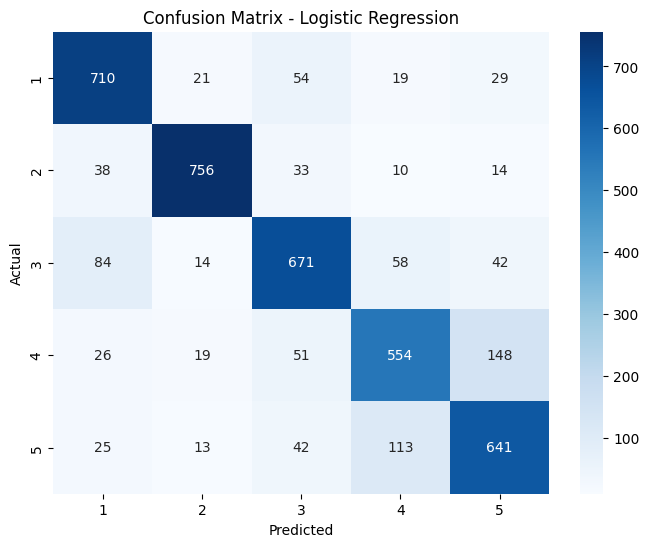

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
X, y = balanced_df['comment_token'], balanced_df['n_star']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
count_vectorizer = CountVectorizer(ngram_range=(1, 5), stop_words=stopword, max_df=0.5, min_df=5)
tfidf_vectorizer = TfidfTransformer(use_idf=False, sublinear_tf = True, norm='l2', smooth_idf=True)

X_train = count_vectorizer.fit_transform(X_train)
X_train = tfidf_vectorizer.fit_transform(X_train)

X_test = count_vectorizer.transform(X_test)
X_test = tfidf_vectorizer.transform(X_test)

# Dự đoán trên tập kiểm tra
y_pred_lr = maxent_model.predict(X_test)

# Tính ma trận nhầm lẫn
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Vẽ ma trận nhầm lẫn bằng seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

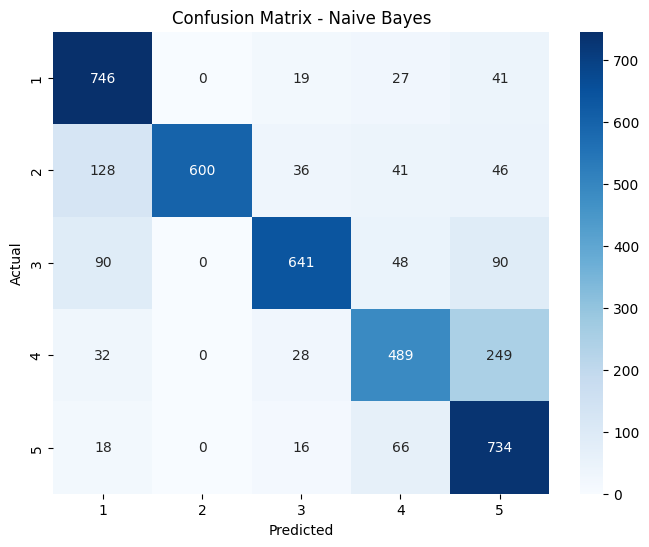

In [ ]:
# Dự đoán trên tập kiểm tra
y_pred_nb = nb_model.predict(X_test)

# Tính ma trận nhầm lẫn
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Vẽ ma trận nhầm lẫn bằng seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

## Áp dụng mô hình

In [ ]:
import joblib  # Import để load mô hình

# ## Lưu trữ mô hình để khai thác về sau
joblib.dump(maxent_model, folder + '/Output/maxent_model.pkl')

['/content/drive/MyDrive/Tài liệu học tập/HK5/Xử lý ngôn ngữ tự nhiên/NLP/Output/maxent_model.pkl']

In [ ]:
balanced_df.to_csv(folder + '/Data/balanced_df.csv')

In [ ]:
def predict_rate(text):
    text = text_preprocess(text)
    text = text_preprocess2(text)
    text = underthesea.word_tokenize(text, format="text")

    balanced_df = pd.read_csv(folder +'/Data/balanced_df.csv')
    X, y = balanced_df['comment_token'], balanced_df['n_star']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
    count_vectorizer = CountVectorizer(ngram_range=(1, 5), stop_words=stopword, max_df=0.5, min_df=5)
    tfidf_vectorizer = TfidfTransformer(use_idf=False, sublinear_tf = True, norm='l2', smooth_idf=True)

    X_train = count_vectorizer.fit_transform(X_train)
    X_train = tfidf_vectorizer.fit_transform(X_train)

    X_test = count_vectorizer.transform([text])
    X_test = tfidf_vectorizer.transform(X_test)
    # Dự đoán dữ liệu mới
    maxent_model = joblib.load(folder + '/Output/maxent_model.pkl')
    y_pre = maxent_model.predict(X_test)
    return str(y_pre[0])

In [ ]:
text = input("Bạn thấy sản phẩm điện thoại này như thế nào: ")
print(f'Dự đoán bình luận của bạn là {predict_rate(text)} sao.')

Bạn thấy sản phẩm điện thoại này như thế nào: Màn hình nhạy
Dự đoán bình luận của bạn là 4 sao.


In [ ]:
text = input("Bạn thấy sản phẩm điện thoại này như thế nào: ")
print(f'Dự đoán bình luận của bạn là {predict_rate(text)} sao.')

# Thiết kế giao diện người dùng

In [ ]:
pip install -U gradio

In [ ]:
import gradio as gr
def combine(a):
    return predict_rate(a) + '⭐' # Chỗ này điền dự đoán của mô hình


def mirror(x):
    return x

    import gradio as gr



with gr.Blocks() as demo:

    txt = gr.Textbox(label="Bạn thấy sản phẩm điện thoại này như thế nào", lines=2)
    txt_2 = gr.Textbox(value="", label="Kết quả đánh giá")
    btn = gr.Button(value="Submit")
    btn.click(combine, inputs=[txt], outputs=[txt_2])
    gr.Markdown("## Đánh giá ví dụ")
    gr.Examples(
        ["Tôi thấy sản phẩm này đẹp", "Cấu hình máy mạnh", "Máy chạy quá chậm"],
        [txt],
        txt_2,
        combine,
        cache_examples=True)


if __name__ == "__main__":
    demo.launch()